Testing for an audio processing feature, based on Audacity's noise reduction and loudness normalization features.

TODO: 
- Find a way to measure average silence length

In [2]:
#relative path finder 
import os

def pathfinder (base_path, target_path):
    relative_path = os.path.relpath(target_path, start=os.path.dirname(base_path))
    return relative_path



base_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\NoiseFilteringTest\NoiseFiltering.ipynb"
target_path = r"G:\Cloned Repos\Repo prueba 1\Binary-class\Dataset-custom-audio\audio-standby-files\noise-profile\Noise.wav"

path=pathfinder(base_path, target_path)
print(path)


..\Dataset-custom-audio\audio-standby-files\noise-profile\Noise.wav


# Step One: Normalization

For this section, we will use ffmpeg-normalize. More information [here](https://pypi.org/project/ffmpeg-normalize/).

In [3]:
import ffmpeg_normalize as normalizer
import torch

In [4]:
# For this and for denoiser, we'll use the same settings used in Audacity.
normalize = normalizer.FFmpegNormalize(normalization_type='ebu', target_level=-23, dual_mono=True, print_stats=True)
normalize.add_media_file("../Dataset-custom-audio/test-audio-not-split/010123.wav", "Normalized-010123.wav")
normalize.run_normalization()

You specified linear normalization, but the loudnorm filter reverted to dynamic normalization. This may lead to unexpected results.Consider your input settings, e.g. choose a lower target level or higher target loudness range.


[
    {
        "input_file": "../Dataset-custom-audio/test-audio-not-split/010123.wav",
        "output_file": "Normalized-010123.wav",
        "stream_id": 0,
        "ebu_pass1": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -22.83,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -32.83,
            "normalization_type": "dynamic",
            "target_offset": -0.17
        },
        "ebu_pass2": {
            "input_i": -46.01,
            "input_tp": -23.21,
            "input_lra": 1.3,
            "input_thresh": -56.01,
            "output_i": -23.0,
            "output_tp": -2.0,
            "output_lra": 0.8,
            "output_thresh": -33.0,
            "normalization_type": "dynamic",
            "target_offset": -0.0
        },
        "mean": null,
        "max": null
    }
]


# Step Two: Noise Reduction

Based on Audacity's noise reduction, using noisereduce. More information [here](https://pypi.org/project/noisereduce/).


In [5]:
# Remove this comment to install noisereduce if needed
#%pip install noisereduce

In [6]:
import noisereduce as nr
from scipy.io import wavfile

#setting up device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


In [7]:
# obtain normalized file
rate_normal, data_normal = wavfile.read("Normalized-010123.wav")

In [8]:
device

'cuda'

## Stationary Noise

Stationary Noise Reduction acts on noise that is stationary in intensity and shape over time, like the hum of electronics.

In [9]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12

#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, stationary=True, prop_decrease=2.0, freq_mask_smooth_hz=375,device=device)
wavfile.write("reduced_noise_stat.wav", rate_normal, reduced_noise)

## Non-stationary Noise

Non-stationary noise reduction targets background noise that is non-stationary and fluctuates over time, like the presence of an airplane flying overhead.

In [92]:
import matplotlib.pyplot as plt
from scipy.signal import resample

C:\Users\Kat\AppData\Local\Temp\ipykernel_171960\2508538835.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized


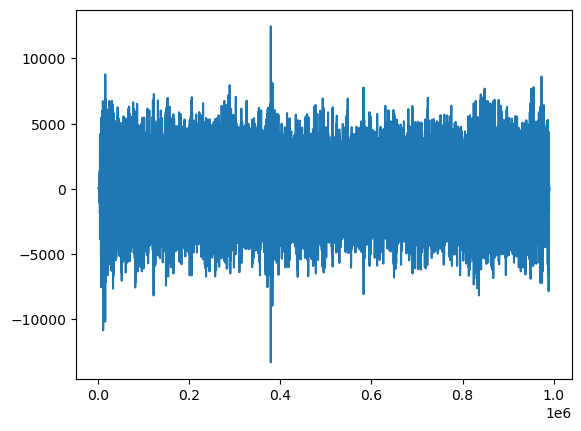

In [94]:
noise_rate, noise_data = wavfile.read("../Dataset-custom-audio/audio-standby-files/noise-profile/Noise.wav") # noise profile, pre-normalized
plt.plot(noise_data)
plt.show()

In [95]:
# Noise Reduction: 16 dB. Sensitivity: 2.0. Frequency smoothing bands: 12
#perform noise reduction
reduced_noise = nr.reduce_noise(y=data_normal, sr=rate_normal, y_noise=noise_data, stationary=False, prop_decrease=2.0, freq_mask_smooth_hz=375,device=device)
wavfile.write("reduced_noise_nonstat.wav", rate_normal, reduced_noise)

## Graphs

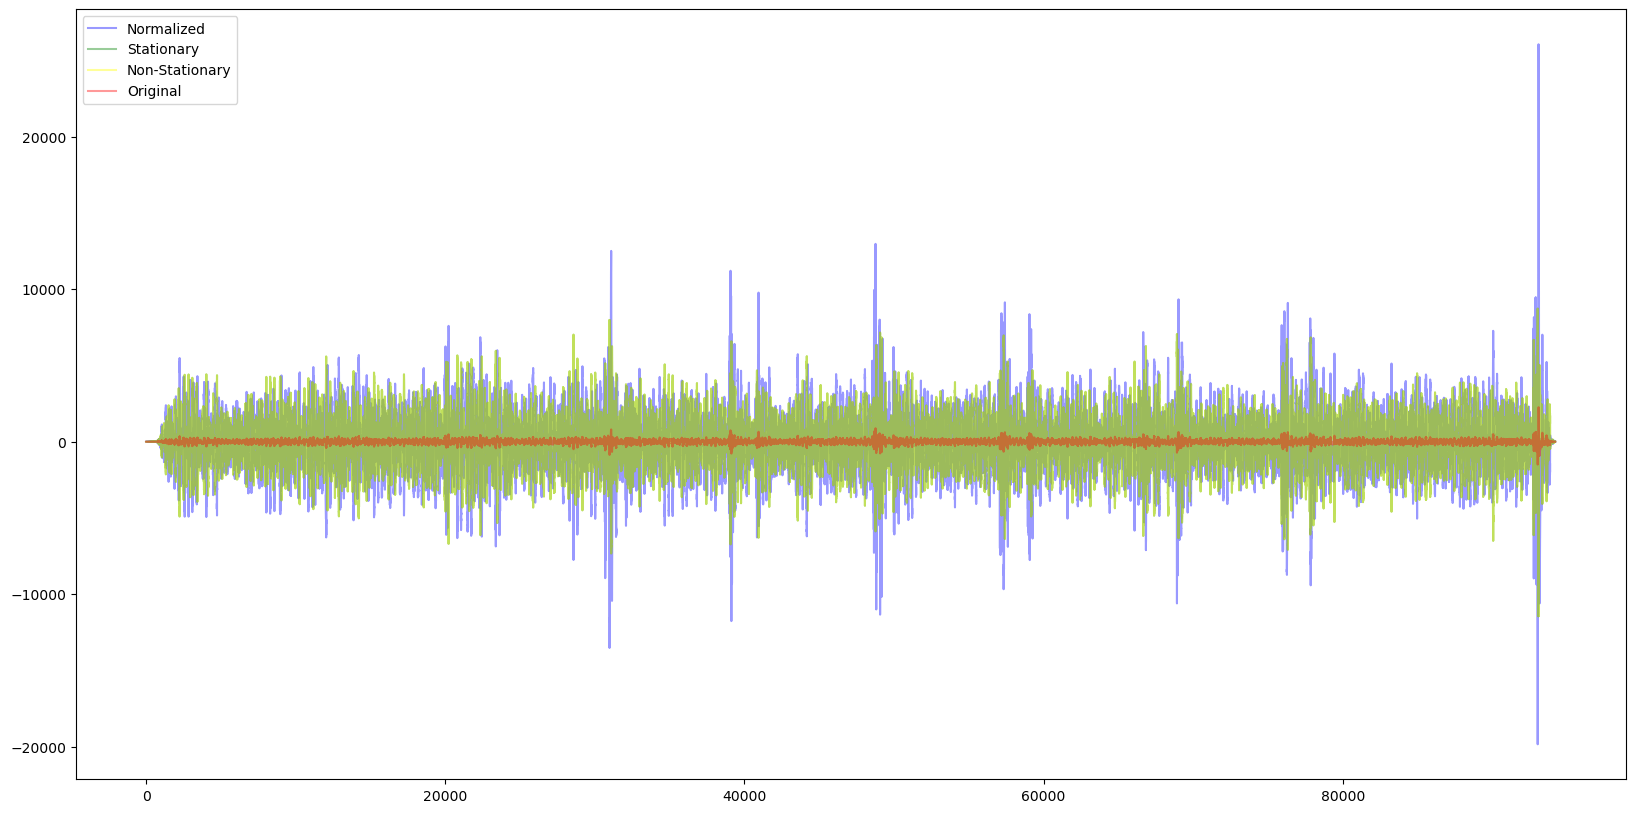

In [96]:
plt.figure(figsize=(20,10))
common_rate = 16000 #common sample rate for graphing

#graph normalized
data_normal_resampled = resample(data_normal, int(len(data_normal)*common_rate/rate_normal))
plt.plot(data_normal_resampled, label="Normalized", color="blue", alpha=0.4)

#graph stationary
_, data_stat = wavfile.read("reduced_noise_stat.wav")
data_stat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_stat_resampled, label="Stationary", color="green", alpha=0.4)

#graph nonstationary
_, data_nonstat = wavfile.read("reduced_noise_stat.wav")
data_nonstat_resampled = resample(data_stat, int(len(data_stat)*common_rate/_))
plt.plot(data_nonstat_resampled, label="Non-Stationary", color="yellow", alpha=0.4)

#og
_,data_og = wavfile.read("../Dataset-custom-audio/test-audio-not-split/010123.wav")
#resampling with others' rate
data_og_resampled = resample(data_og, int(len(data_og)*common_rate/_))
plt.plot(data_og_resampled, label="Original", color="red", alpha=0.4)

plt.legend()
plt.show()

# Comparing noise filtering methods for peak identification

In [97]:
import pydub
import pydub.silence
import numpy as np

def match_target_amplitude (aChunk, target_dBFS): #normalizing audio
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

def split_audio(audio, silence_length):
    #find average dbfs of audio first
    average=audio.dBFS

    #splitting audio
    chunks = pydub.silence.split_on_silence(
        audio, #audio file
        min_silence_len=silence_length, #length of required silence chunk in ms
        silence_thresh=average) #a chunk is silent if it's below this threshold
    
    # Convert chunks to numpy arrays
    chunk_arrays = [np.array(chunk.get_array_of_samples()) for chunk in chunks]

    
    #return amount of chunks
    return len(chunks), chunk_arrays


#load audio files
audio_base = pydub.AudioSegment.from_file("../Dataset-custom-audio/test-audio-not-split/010123.wav")
audio_normalized = pydub.AudioSegment.from_file("Normalized-010123.wav")
audio_stat = pydub.AudioSegment.from_file("reduced_noise_stat.wav")
audio_nonstat = pydub.AudioSegment.from_file("reduced_noise_nonstat.wav")

## Base audio and Normalized only

In [98]:
base_chunks_n,base_chunks=split_audio(audio_base,200)
normalized_chunks_n,normalized_chunks=split_audio(audio_normalized,200)

print("Base chunks: ", base_chunks_n)
print("Normalized chunks: ", normalized_chunks_n)

Base chunks:  7
Normalized chunks:  7


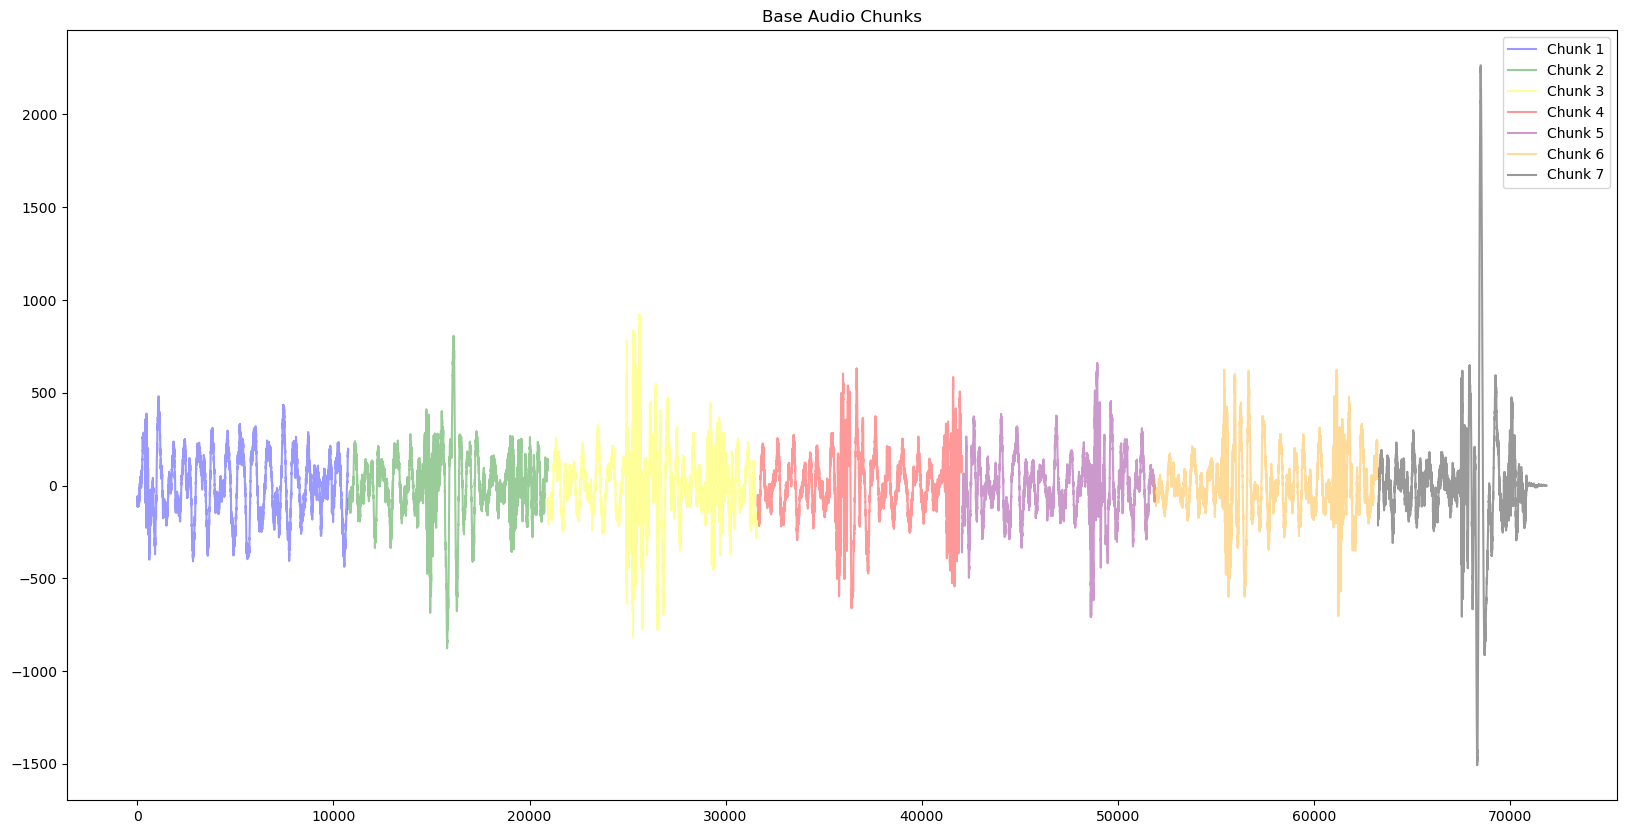

In [99]:
# Calculate the lengths of each chunk
chunk_lengths_base = [len(chunk) for chunk in base_chunks]
x_offset_base = np.cumsum([0]+chunk_lengths_base[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray']	

for i, (chunk, x_offset_base) in enumerate(zip(base_chunks, x_offset_base)):
    x=np.arange(len(chunk))+x_offset_base
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Base Audio Chunks")
plt.legend()
plt.show()


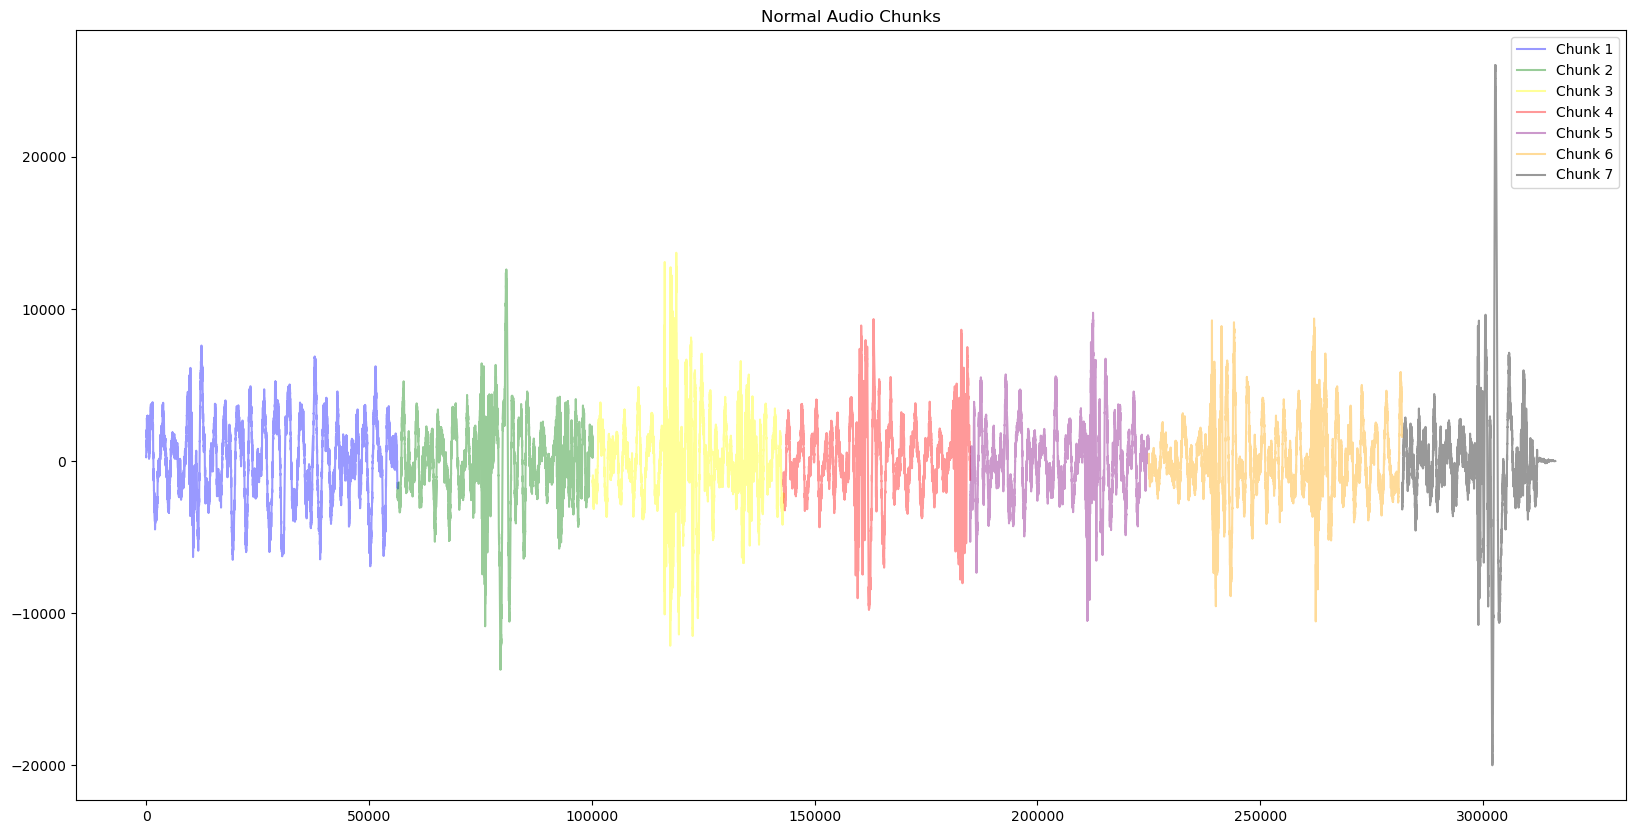

In [100]:
# Calculate the lengths of each chunk
chunk_lengths_normal = [len(chunk) for chunk in normalized_chunks]
x_offset_normal = np.cumsum([0]+chunk_lengths_normal[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray']	

for i, (chunk, x_offset_normal) in enumerate(zip(normalized_chunks, x_offset_normal)):
    x=np.arange(len(chunk))+x_offset_normal
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Normal Audio Chunks")
plt.legend()
plt.show()

## Stationary denoising

In [101]:
stat_chunks_n,stat_chunks=split_audio(audio_stat,200)

print("Stationary chunks: ", stat_chunks_n)

Stationary chunks:  8


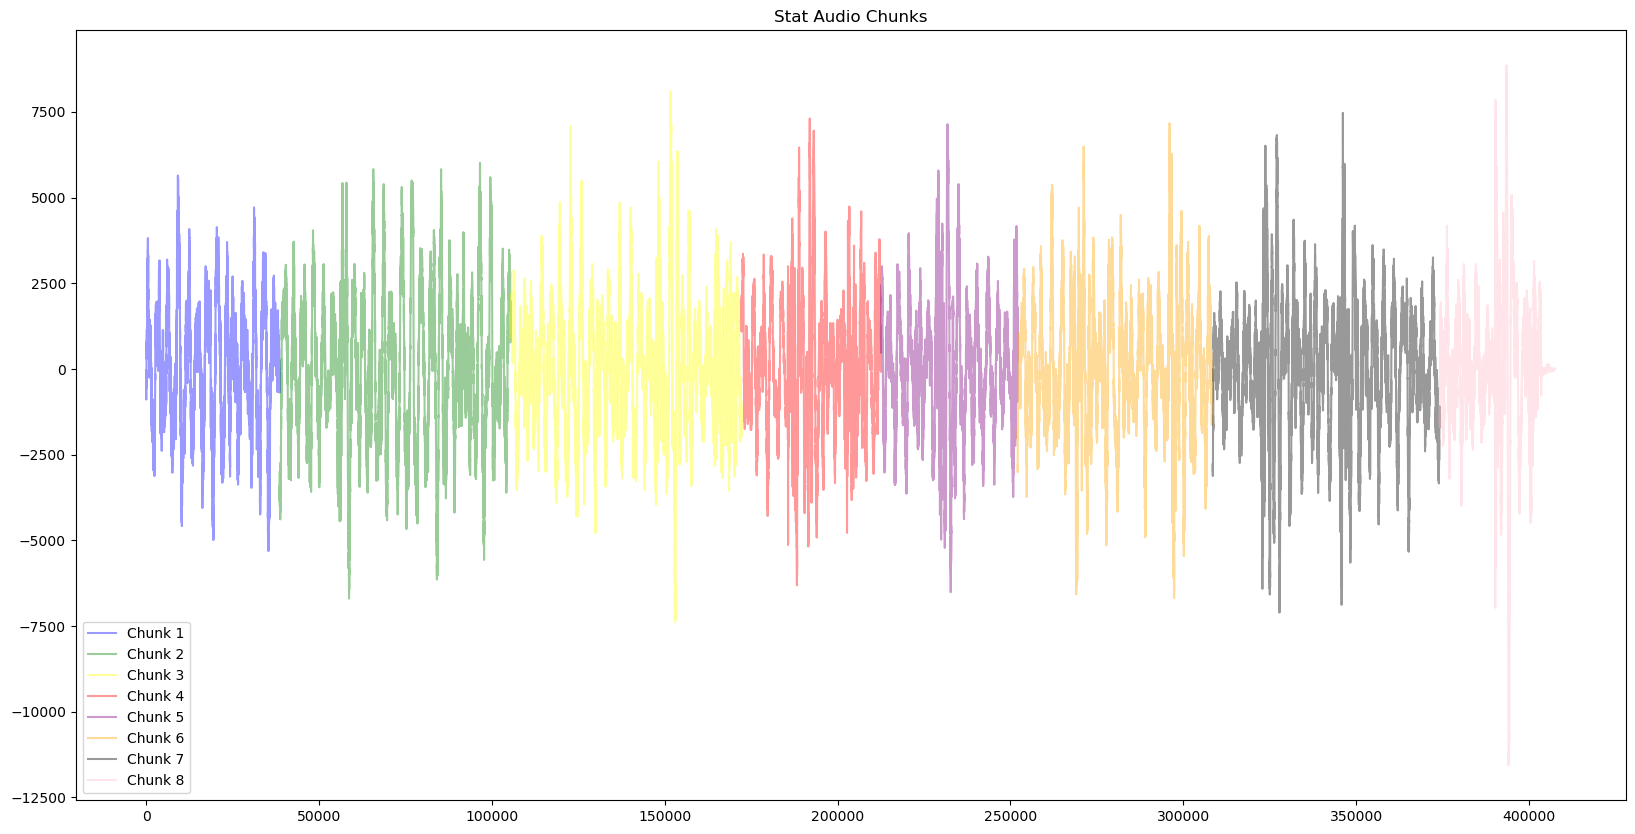

In [102]:
# Calculate the lengths of each chunk
chunk_lengths_stat = [len(chunk) for chunk in stat_chunks]
x_offset_stat = np.cumsum([0]+chunk_lengths_stat[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray']	

for i, (chunk, x_offset_stat) in enumerate(zip(stat_chunks, x_offset_stat)):
    x=np.arange(len(chunk))+x_offset_stat
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Stat Audio Chunks")
plt.legend()
plt.show()

## Non-stationary denoising

In [75]:
nonstat_chunks_n,nonstat_chunks=split_audio(audio_nonstat,200)

print("Non-Stationary chunks: ", nonstat_chunks_n)

Non-Stationary chunks:  7


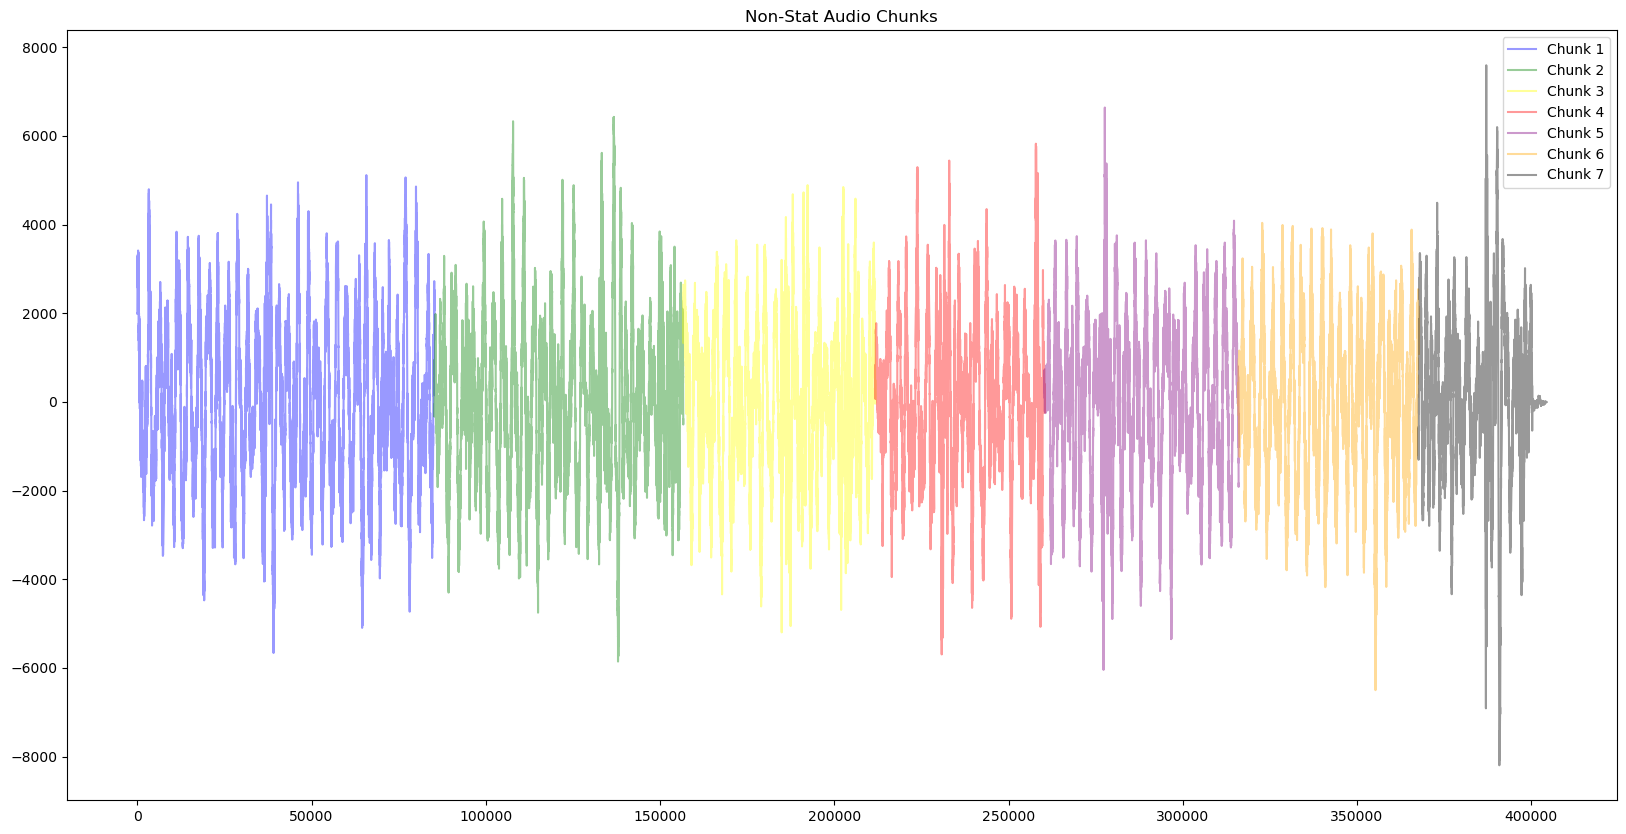

In [81]:
# Calculate the lengths of each chunk
chunk_lengths_nonstat = [len(chunk) for chunk in nonstat_chunks]
x_offset_nonstat = np.cumsum([0]+chunk_lengths_nonstat[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray']	

for i, (chunk, x_offset_nonstat) in enumerate(zip(nonstat_chunks, x_offset_nonstat)):
    x=np.arange(len(chunk))+x_offset_nonstat
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Non-Stat Audio Chunks")
plt.legend()
plt.show()

## Splitting audio by average chunk calculation

This one is a bad idea and we shouldn't do it!

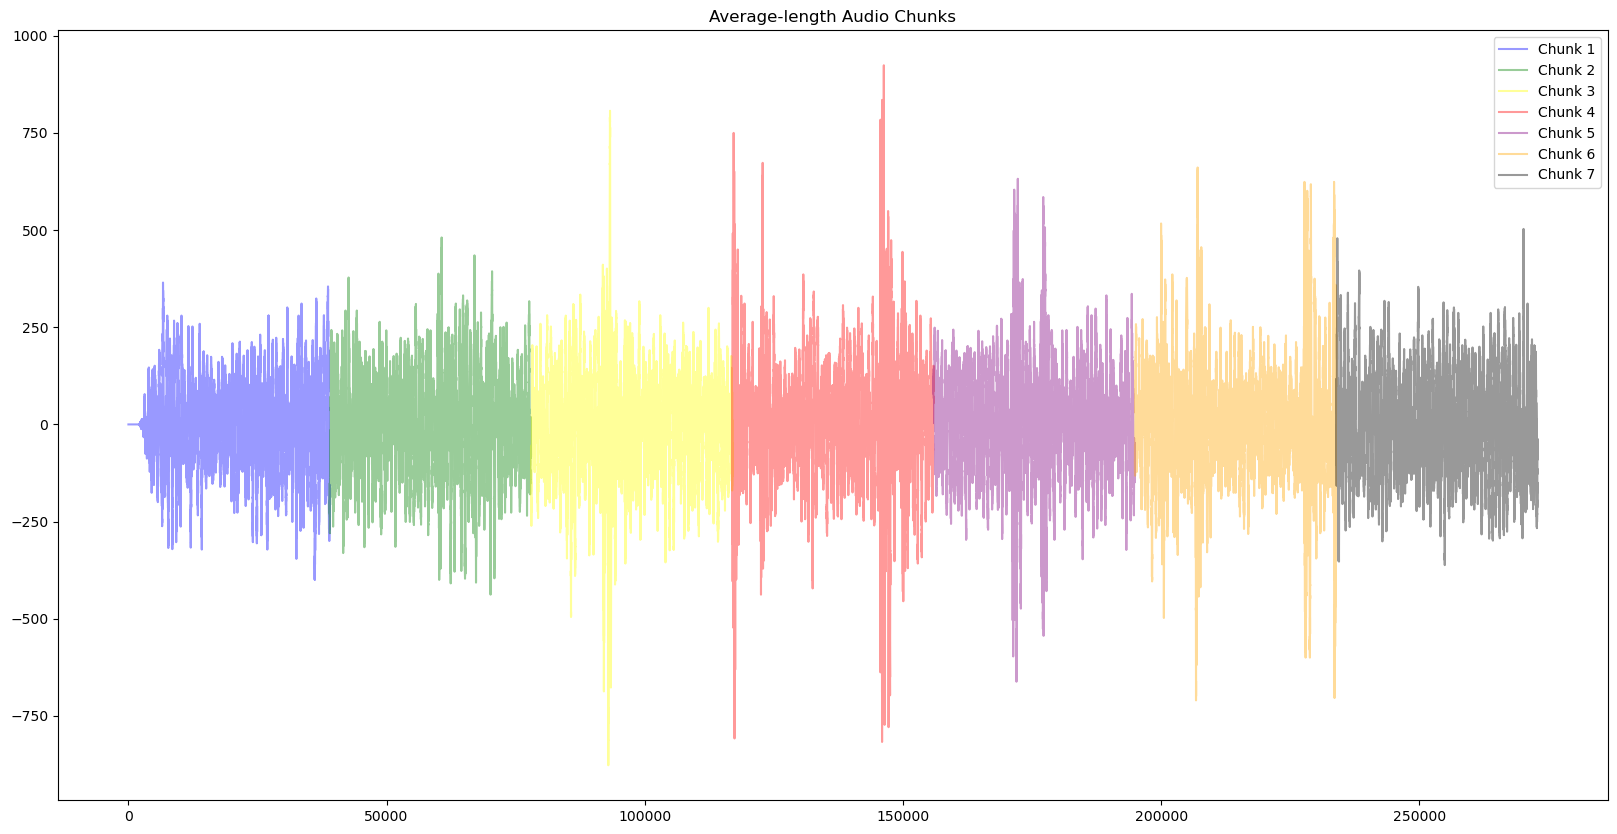

In [83]:
# average chunk count
average_chunk_count = (base_chunks_n+normalized_chunks_n+stat_chunks_n+nonstat_chunks_n)/4

#split audio by average chunk count
def split_audio_count(audio, n_chunks):
    #calculate chunk length
    length=len(audio)/n_chunks

    #split audio
    chunks=[audio[i*length:(i+1)*length] for i in range(int(n_chunks))]
    
    # Convert chunks to numpy arrays
    chunk_arrays = [np.array(chunk.get_array_of_samples()) for chunk in chunks]
    
    #return amount of chunks
    return len(chunks), chunk_arrays

#splitting
average_chunk_n, average_chunks = split_audio_count(audio_base, average_chunk_count)

#graph that shit
# Calculate the lengths of each chunk
chunk_lengths_avg = [len(chunk) for chunk in average_chunks]
x_offset_avg = np.cumsum([0]+chunk_lengths_avg[:-1])

#graph this
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray']	

for i, (chunk, x_offset_avg) in enumerate(zip(average_chunks, x_offset_avg)):
    x=np.arange(len(chunk))+x_offset_avg
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Average-length Audio Chunks")
plt.legend()
plt.show()

# Another Attempt with the key audio

In [103]:
audio_key_0_normal = pydub.AudioSegment.from_file("../Dataset-custom-audio/base-audio-normalized-only/0.wav")
audio_key_0_denoised = pydub.AudioSegment.from_file("../Dataset-custom-audio/base-audio-denoised-normalized/0.wav")

In [113]:
normal_chunks_n_0,normal_chunks_0=split_audio(audio_key_0_normal,150)
denoised_chunks_n_0,denoised_chunks_0=split_audio(audio_key_0_denoised,120)

print("Normalized chunks: ", normal_chunks_n_0)
print("Denoised chunks: ", denoised_chunks_n_0)

Normalized chunks:  41
Denoised chunks:  40


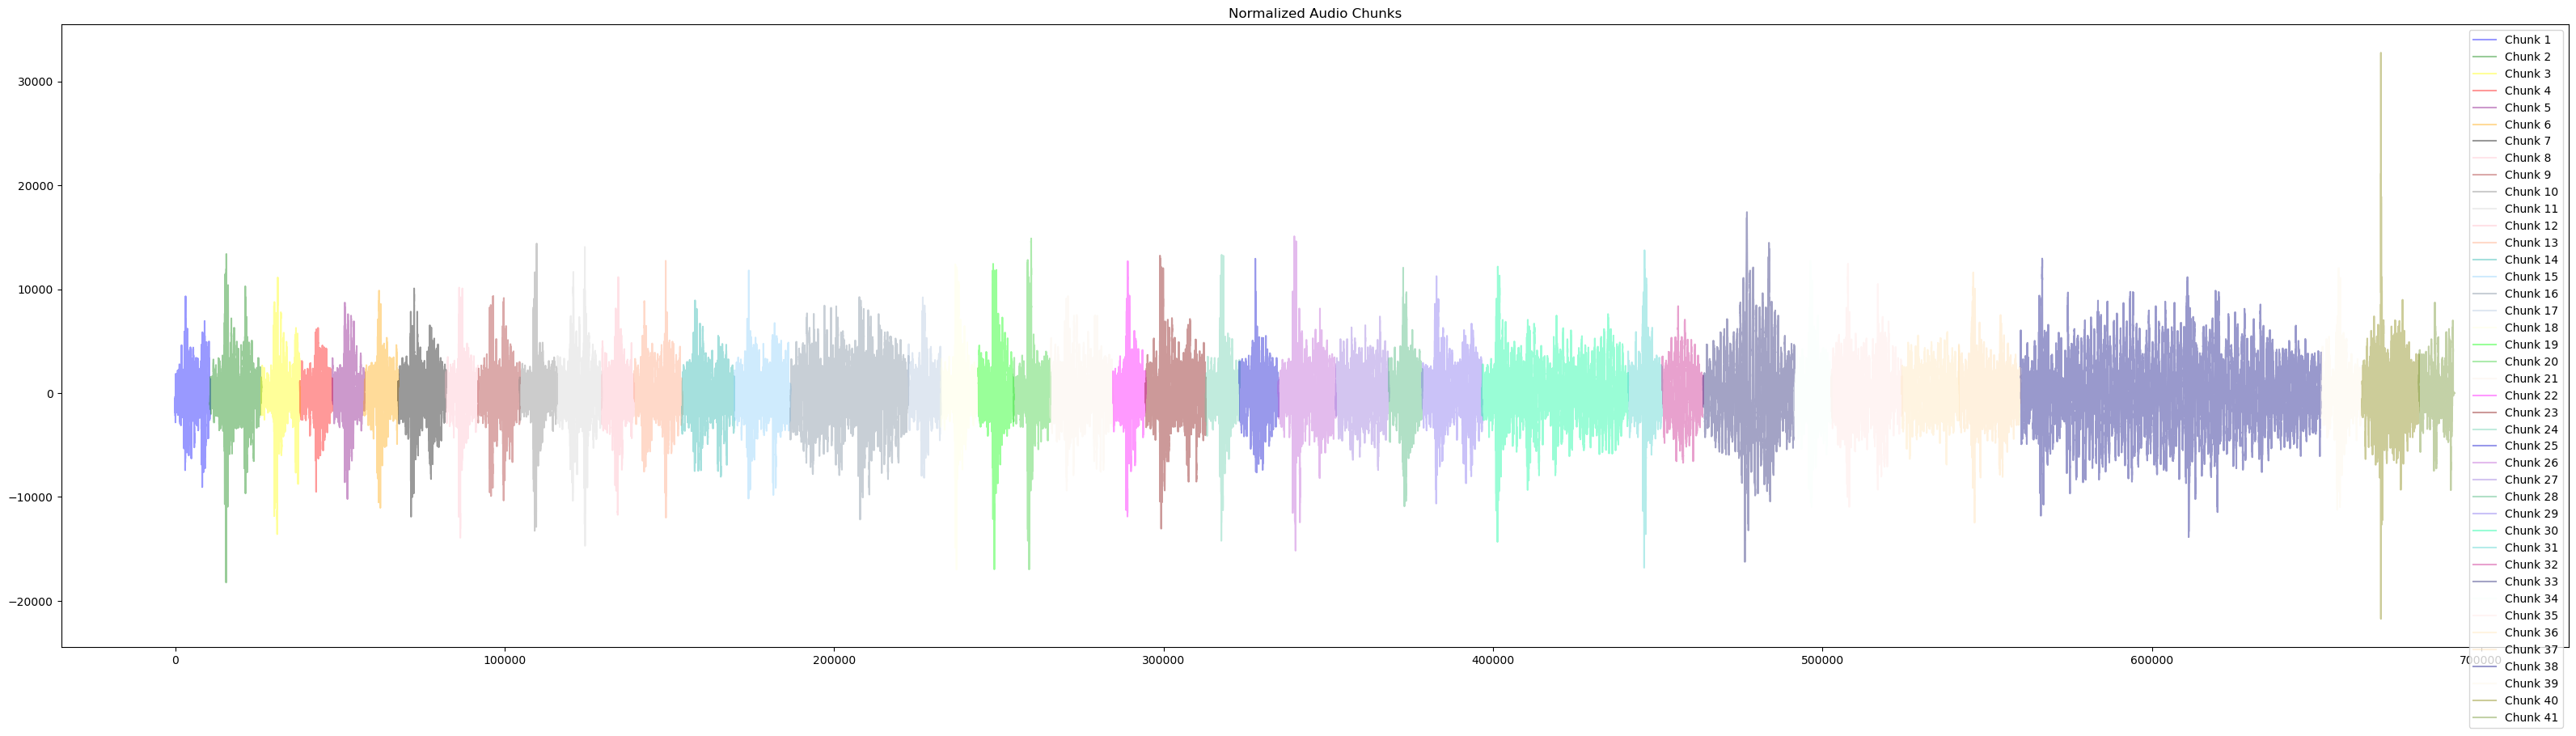

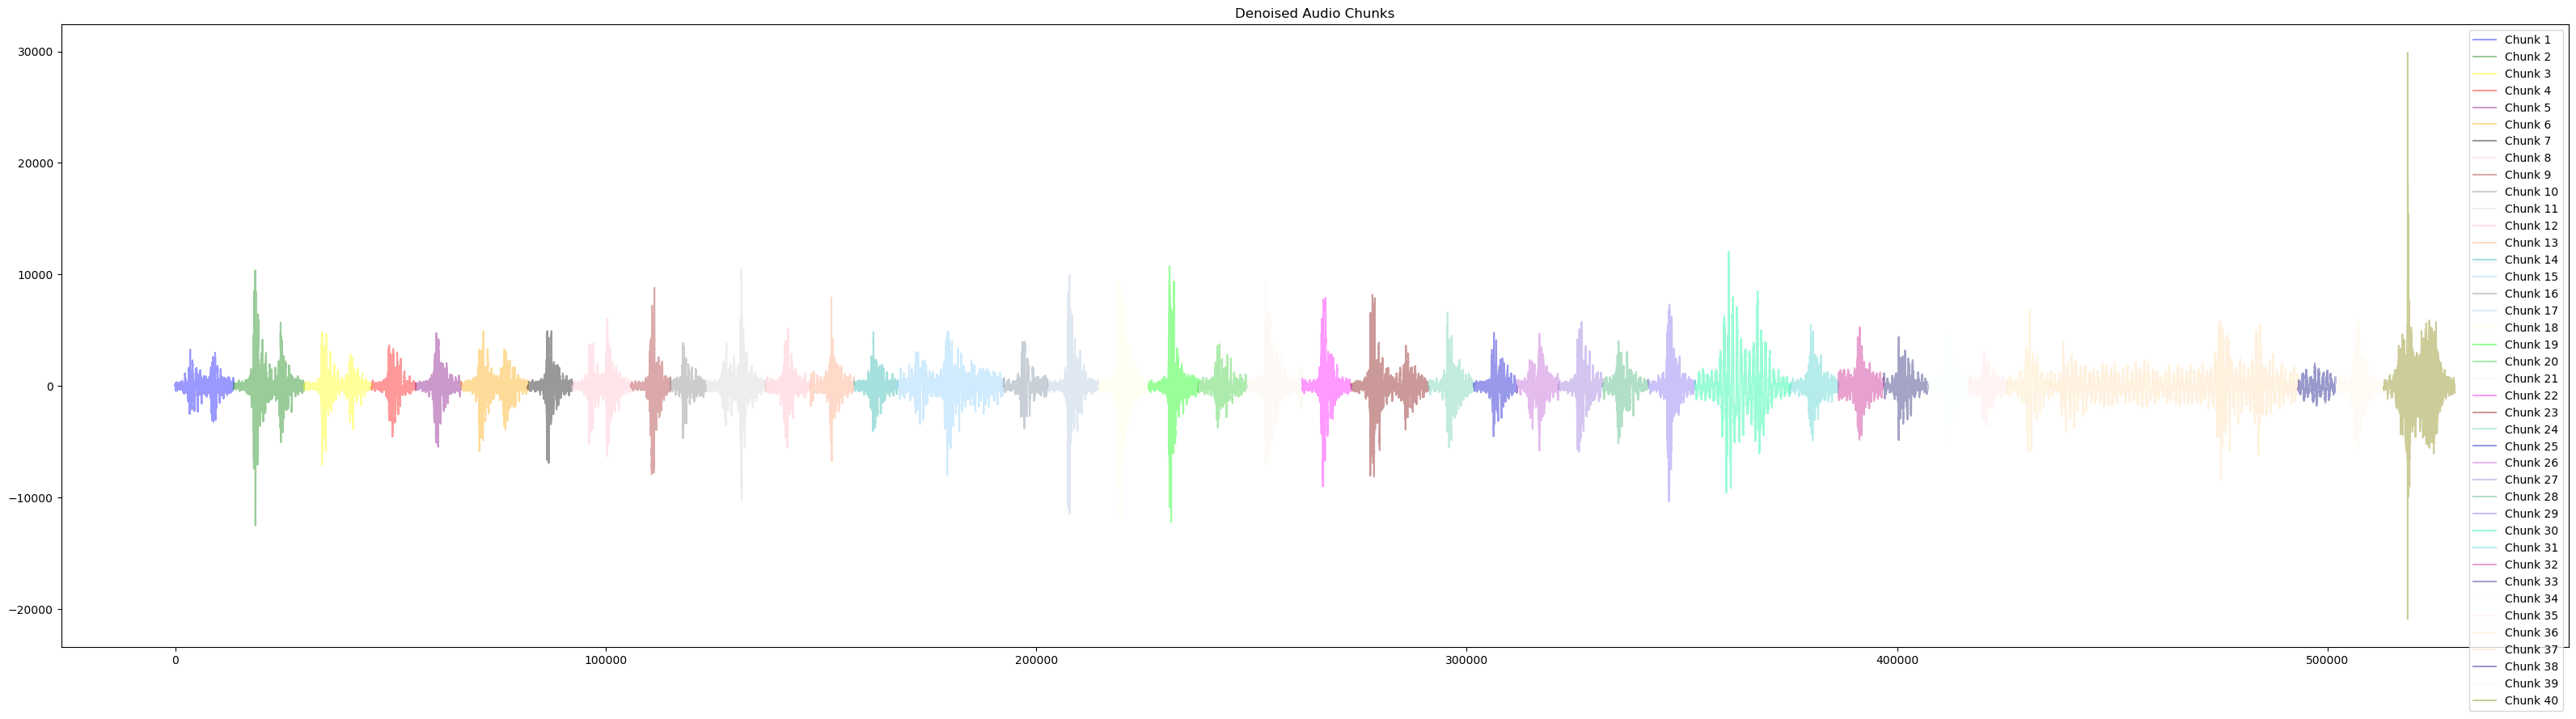

In [117]:
# Calculate the lengths of each chunk - normalized
chunk_lengths_n0 = [len(chunk) for chunk in normal_chunks_0]
x_offset_normal_0 = np.cumsum([0]+chunk_lengths_n0[:-1])

#graph this
plt.figure(figsize=(40,10))
colors=['blue','green','yellow','red','purple','orange','black','pink','brown','gray', 'lightgrey','lightpink','lightsalmon','lightseagreen','lightskyblue','lightslategray','lightsteelblue','lightyellow','lime','limegreen','linen','magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen','mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','mintcream','mistyrose','moccasin','navajowhite','navy','oldlace','olive','olivedrab','orange','orangered','orchid','palegoldenrod','palegreen','paleturquoise','palevioletred','papayawhip','peachpuff','peru','pink','plum','powderblue','purple','rebeccapurple','rosybrown','royalblue','saddlebrown','salmon','sandybrown','seagreen','tomato','seashell','sienna','silver','skyblue','slateblue','slategray','snow','steelblue','tan','teal','thistle','turquoise','violet','wheat','whitesmoke','yellowgreen']	

for i, (chunk, x_offset_normal_0) in enumerate(zip(normal_chunks_0, x_offset_normal_0)):
    x=np.arange(len(chunk))+x_offset_normal_0
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Normalized Audio Chunks")
plt.legend()
plt.show()

# Calculate the lengths of each chunk - denoised
chunk_lengths_d0 = [len(chunk) for chunk in denoised_chunks_0]
x_offset_denoised_0 = np.cumsum([0]+chunk_lengths_d0[:-1])

#graph this
plt.figure(figsize=(40,10))

for i, (chunk, x_offset_denoised_0) in enumerate(zip(denoised_chunks_0, x_offset_denoised_0)):
    x=np.arange(len(chunk))+x_offset_denoised_0
    plt.plot(x, chunk, label=f"Chunk {i+1}", color=colors[i], alpha=0.4)

plt.title("Denoised Audio Chunks")
plt.legend()
plt.show()